In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Integrating ideal data

## Select an initial position and step of time

Latitude and longitude of Paris:

In [2]:
lat_Paris = 48.8534 # degrees
lon_Paris = 2.3488  # degrees
alt_Paris = 35      # meters

We are going to use IMU readings so we set high sampling period and one hour trajectories.

In [3]:
dt = 0.1 # s
duration = 3600 # s
n_samples = int(duration/dt)
step_plot = int(60/dt) # display of one point per min.

## 1. Stationary pos above Paris

### Trajectory definition

Set $Cnb = I_{n samplesx3x3}$ :

In [4]:
I3 = np.identity(3) 
Cnb = np.repeat(I3[None,...],n_samples,axis=0)

Set North and east velocities to zeros:

In [5]:
VN = np.zeros(n_samples-1)
VE = VU = VN

### Generate inertial readings:

In [6]:
from pyins import sim

In [7]:
%%time
gyros, accels = sim.stationary_rotation(dt, lat_Paris, alt_Paris, Cnb)

Wall time: 379 ms


The inertial readings are drawn below

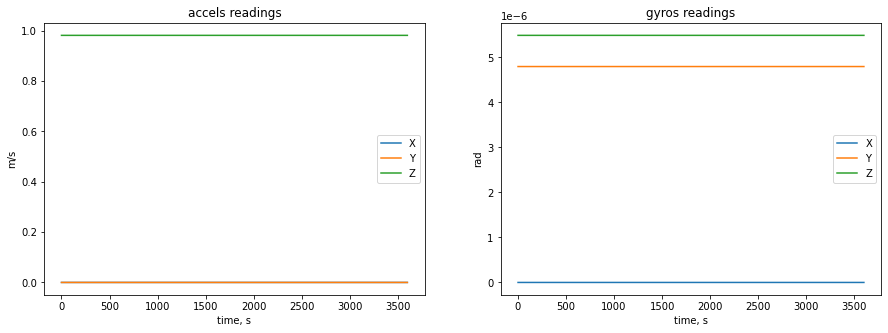

In [8]:
from helper import plot_inertial_readings

plot_inertial_readings(dt, gyros, accels)

A quick test to understand these measures :

In [9]:
from pyins import earth
g = earth.gravity(np.sin(np.deg2rad(lat_Paris)), alt_Paris)
wT = earth.RATE

eps = np.finfo(np.float32).eps
if(dt*g - accels[0,2] < eps): print("The z component of the accels corresponds to gravity")
if(dt*wT - np.linalg.norm(gyros[0,:])  < eps): print("and the earth trurn at the right speed.")

The z component of the accels corresponds to gravity
and the earth trurn at the right speed.


### Integrating IMU data :

In [10]:
from pyins.integrate import coning_sculling, integrate
from pyins.filt import traj_diff

First we apply coning and sculling corrections:

In [11]:
theta, dv = coning_sculling(gyros, accels)

Initial conditions for integration: 

In [12]:
from pyins.dcm import _to_hpr_array, from_hpr

In [13]:
h, p, r = _to_hpr_array(Cnb)

And the run the integration.

In [14]:
%%time
traj_ideal = integrate(dt, lat_Paris, lon_Paris, VN[0], VE[0], h[0], p[0], r[0], theta, dv)

Wall time: 250 ms


### Errors Calculation 

Creation of the pandas data frame for the reference trajectory :

In [15]:
n = accels.shape[0]
traj_ref = pd.DataFrame(index=np.arange(n))
traj_ref['lat'] = lat_Paris*np.ones(n)
traj_ref['lon'] = lon_Paris*np.ones(n)
traj_ref['alt'] = alt_Paris*np.ones(n)
traj_ref['VE'] = VE
traj_ref['VN'] = VN
traj_ref['VU'] = VU 
traj_ref['h'] = h[1:]
traj_ref['p'] = p[1:]
traj_ref['r'] = r[1:]

In [16]:
from pyins.filt import traj_diff

Compute integration error using a convenience function:

In [17]:
err = traj_diff(traj_ideal, traj_ref)

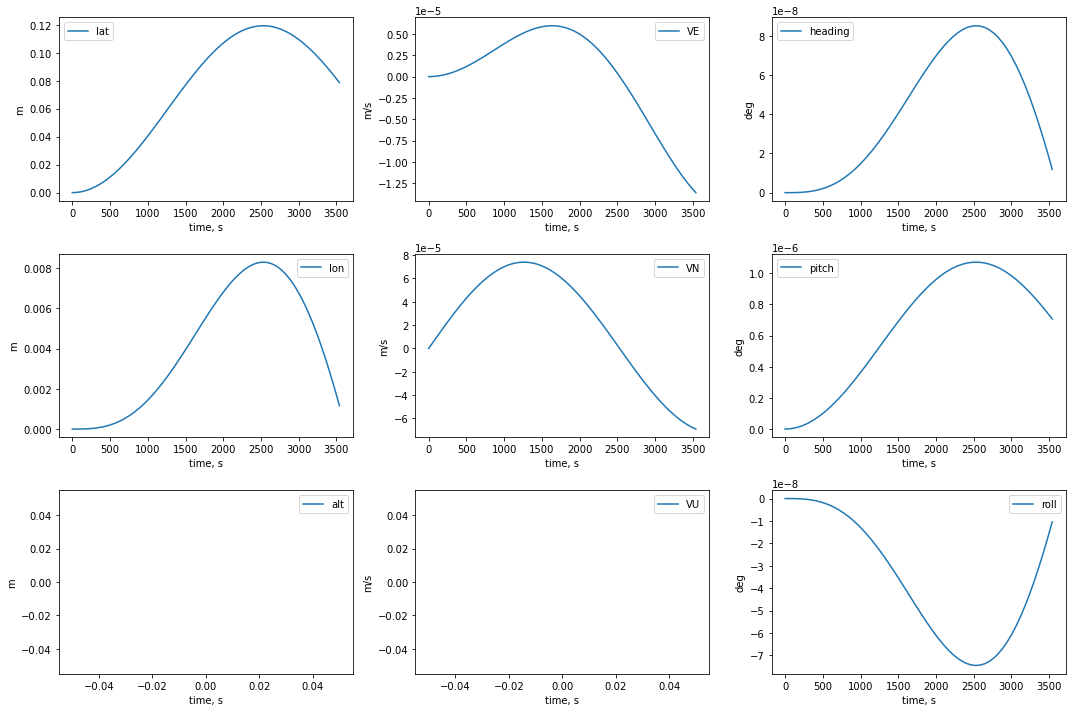

In [18]:
from helper import plot_traj
plot_traj(dt, err, step_plot, coord_unit="m")

## 2. Straight line trajectory from Paris

### Trajectory definition

We will use a straight and level flight as a trajectory.

We specify the trajectory with time series of latitudes and longitudes and corresponding time stamps.

In [19]:
lat = np.tile(lat_Paris , n_samples)
lon = np.linspace(lon_Paris, lon_Paris + 35, n_samples)
alt = np.tile(3500, n_samples)
h = np.tile(90, n_samples)
p = np.tile(0, n_samples)
r = np.tile(0, n_samples)

### Generate inertial readings

In [20]:
%%time
traj_ref, gyros, accels = sim.from_position(dt, lat, lon, alt, h, p, r)

Wall time: 422 ms


On the plots we see that the velocity as well as the heading are constant.

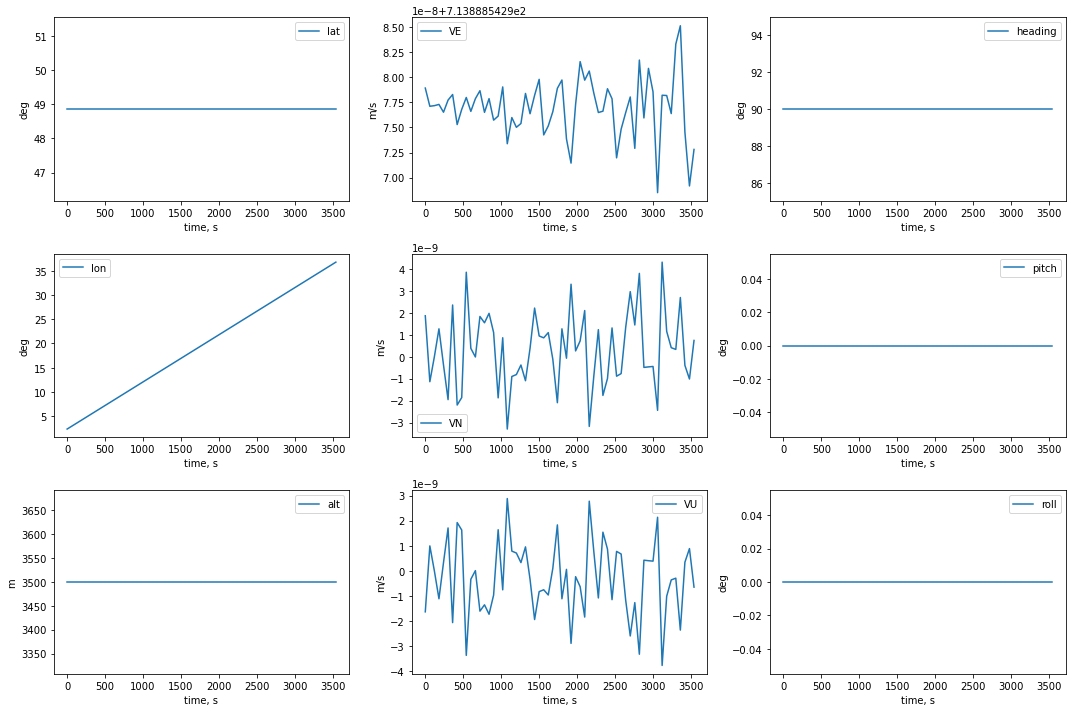

In [21]:
plot_traj(dt, traj_ref, step_plot)

The inertial readings are drawn below:

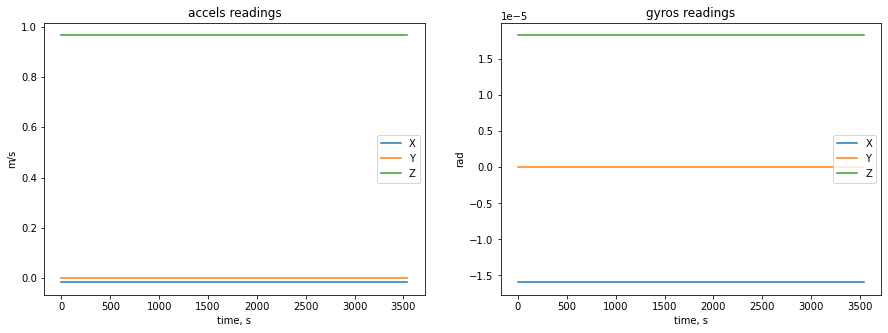

In [22]:
plot_inertial_readings(dt, gyros, accels, step_plot)

### Integrating IMU data

First we apply coning and sculling corrections:

In [23]:
theta, dv = coning_sculling(gyros, accels)

And the run the integration.

In [24]:
%%time
traj_ideal = integrate(dt, traj_ref.lat[0], traj_ref.lon[0],
                           traj_ref.VE[0], traj_ref.VN[0],
                           traj_ref.h[0], traj_ref.p[0], traj_ref.r[0],
                           theta, dv, stamp=0)

Wall time: 226 ms


### Errors Calculation 

Compute and plot integration error using a convenience function:

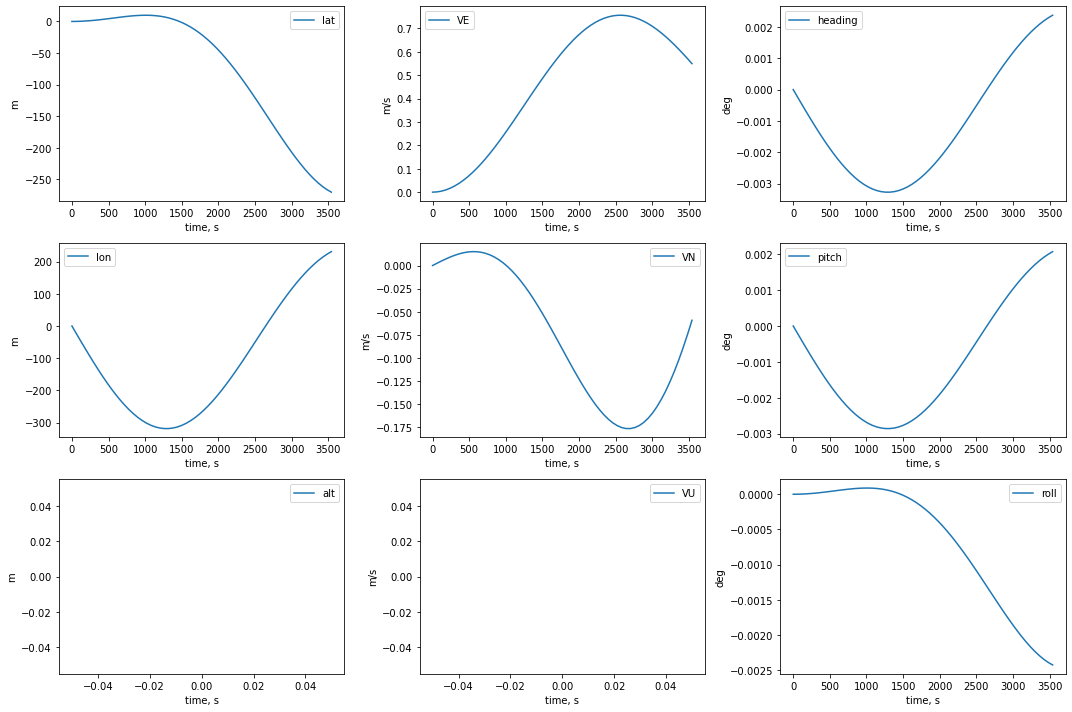

In [25]:
err = traj_diff(traj_ref, traj_ideal)
plot_traj(dt, err, step_plot, coord_unit="m")

## 3. Random trajectory from Paris

We generate a trajectory by interpolating between Waypoints WP randomly defined.

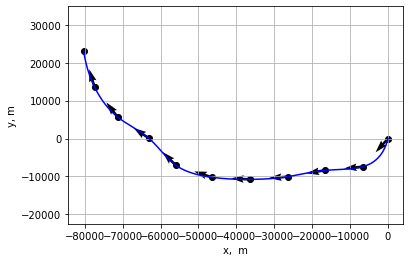

In [26]:
from helper import generate_WP, generate_trajectory

n_move = 10
step = 1e4
angle_spread = 45    

WP, ax = generate_WP(n_move, step, angle_spread, random_state=2)
x, y, h, r = generate_trajectory(n_samples, WP)

ax.plot(x, y, color='blue')
ax.axis('equal')                   
plt.grid()
plt.xlabel("x,  m")
plt.ylabel("y, m")
plt.show()

Add displacements to initial latitude and longitude:

In [27]:
from pyins.coord import perturb_ll

In [28]:
lat, lon = perturb_ll(lat_Paris, lon_Paris, y, x)

Set pitch angle to zeros:

In [29]:
p = np.zeros_like(h)

Run the simulation routine which will interpolate the trajectory and generate inertial readings:

In [30]:
%%time
traj_ref, gyros, accels = sim.from_position(dt, lat, lon, alt, h, p, r)

Wall time: 489 ms


The final trajectory is drawn below, the initial point is marked with a cross.

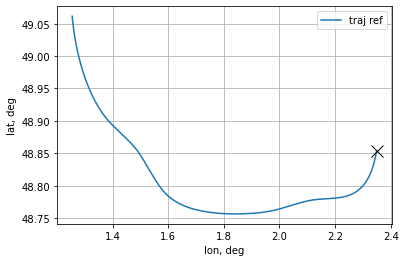

In [31]:
plt.plot(traj_ref.lon, traj_ref.lat, label='traj ref')
plt.plot(traj_ref.lon[0], traj_ref.lat[0], 'kx', markersize=12)
plt.grid()
plt.legend(loc='upper right')
plt.xlabel("lon, deg")
plt.ylabel("lat, deg")
plt.show()

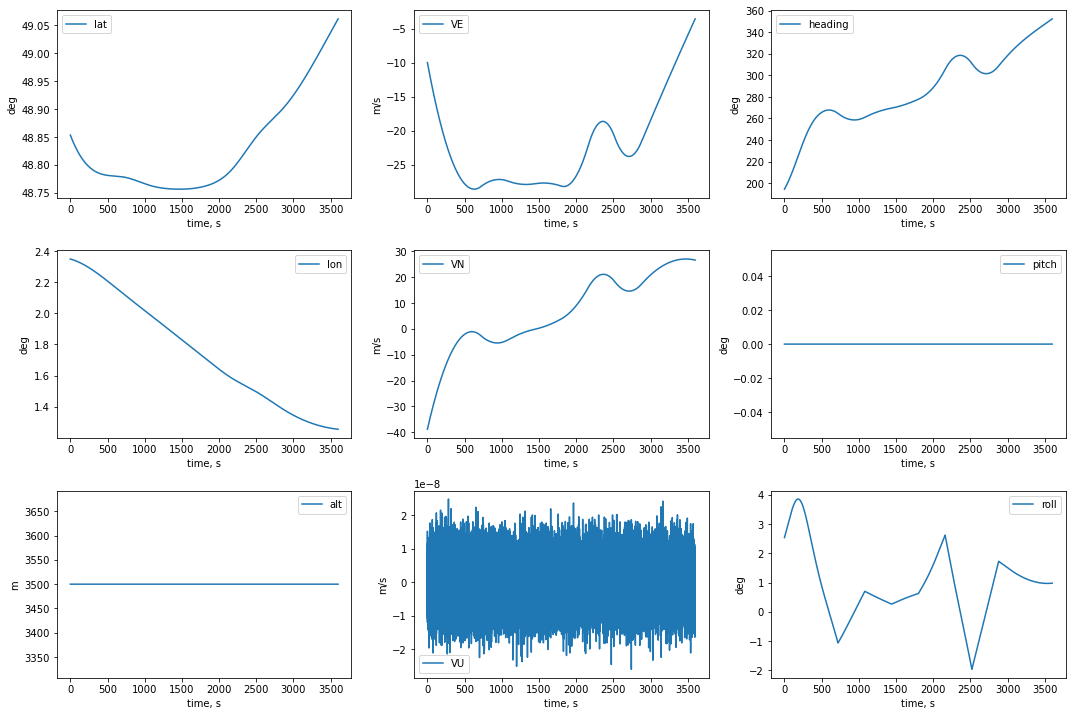

In [32]:
plot_traj(dt, traj_ref)

The inertial readings are drawn below:

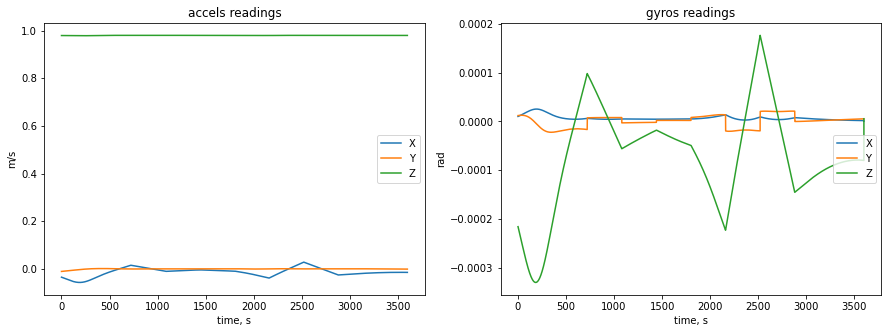

In [33]:
plot_inertial_readings(dt, gyros, accels, 1)

Integrating IMU data:

First we apply coning and sculling corrections:

In [34]:
theta, dv = coning_sculling(gyros, accels)

And the run the integration.

In [35]:
%%time
traj_ideal = integrate(dt, traj_ref.lat[0], traj_ref.lon[0],
                           traj_ref.VE[0], traj_ref.VN[0],
                           traj_ref.h[0], traj_ref.p[0], traj_ref.r[0],
                           theta, dv, stamp=0)

Wall time: 207 ms


Compute and plot integration error using a convenience function:

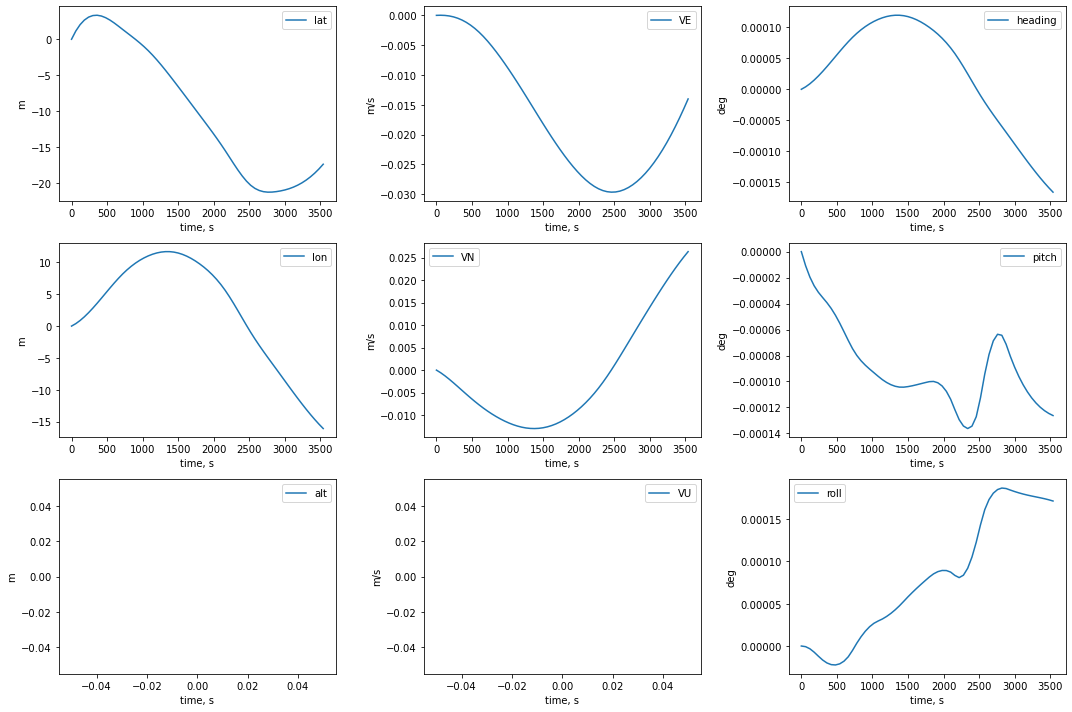

In [36]:
err = traj_diff(traj_ref, traj_ideal)
plot_traj(dt, err, step_plot, coord_unit="m")